# Data 201

Data Wrangling, S2 2021

## Assignement 2

### 20% of final grade

## Due date: 2pm Tuesday 12 October 2021

The assignment must be submitted on the DATA 201 and 422 Learn page and should be **your own pair** (or group of three if we are odd) **work**. Avoid plagiarism: if you are not sure what may constitute code plagiarism, read this http://web.science.mq.edu.au/~mtaylor/ponline/index.php?id=source-code-plagiarism. Remember, when in doubt **declare your sources**.  
As a general rule, late submission are **highly** unsuggested. The pace of the course is very quick, and you don't want to be working on this too long, as you would have less time for other assignments. I suggest you to submit what you have ready by the time the assignment is due, even if it is not everything we required. For any particular problem, please contact [Thomas Li](thomas.li@canterbury.ac.nz) or [Giulio Dalla Riva](giulio.dallariva@canterbury.ac.nz) or TAs.


## Instruction

### Total: 20 marks.

For this assignment you will work with data from the web. Your goal is to scrape it or request it, wrangle it, produce some plotting, in order to demonstrate that you are able to use the functions, plotting, and markdown format we have been learning.  
You shall hand in your work as a jupyter R notebook comprehending the code, the plots and, **very important**, enough comments and explanations for us to understand what you did, how you did it, and why you did it. Remember: better comments, means better marks.  
You can either modify this notebook or write a new one from scratch.

Do use the tidyverse syntax that's introduced in class and labs. If in doubt, refresh the lab material 1 to 7.

### Task (a): scrape it (5 marks)

Identify a website page showing information you find interesting. The information should be presented across more than one page. Select one of this pages (the rest is for later) and using `rvest` (and the suit of `tidyverse` libraries we used so far, plus any other one you may need) get the html into R.

tidyverse: collection of R packages
rvest: read webpage and expore content.

In [20]:


library(tidyverse)
library(rvest)



In [2]:

#use readed course url to get all details we want
get_text <- function(url_readed,selector){
        text_need <- url_readed %>%
                        html_elements(selector) %>%
                        html_text()
        return(text_need)
    }

get_detail <- function(web_url){
    url_readed <- web_url %>% read_html() 
    node_selector <- "#ctl00_ContentPlaceHolder1_CourseCodeLabel"
    course_code <- get_text(url_readed, node_selector)
    if (identical(course_code, character(0))){
        course_code = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_CourseOccurrenceTitleLabel"
    course_name <- get_text(url_readed, node_selector)
    if (identical(course_name, character(0))){
        course_name = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_DomesticFeeLabel"
    Domestic_fee <- get_text(url_readed, node_selector)
    if (identical(Domestic_fee, character(0))){
        Domestic_fee = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_InternationalFeeLabel"
    International_fee <- get_text(url_readed, node_selector)
    if (identical(International_fee, character(0))){
        International_fee = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_StartDateLabel"
    Start_date <- get_text(url_readed, node_selector)
    if (identical(Start_date, character(0))){
        Start_date = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_EndDateLabel"
    End_date <- get_text(url_readed, node_selector)
    if (identical(End_date, character(0))){
        End_date = 'NULL'
    }

    node_selector <- "#ctl00_ContentPlaceHolder1_PointsAndEftsLabel"
    Points <- get_text(url_readed, node_selector)
    if (identical(Points, character(0))){
        Points = 'NULL'
    }
    lecturers <- get_lecturers(url_readed, course_code)
    return(list(course_code, course_name, Domestic_fee, International_fee, Start_date, End_date, Points, lecturers))
}


In [3]:
base_lecturer_url <- 'https://www.canterbury.ac.nz/courseinfo/'
get_lecturers <- function(url_readed, course_code) {
    lecturer_links <- url_readed %>% html_element('#ctl00_ContentPlaceHolder1_ContributorsDiv') %>% html_elements('a')
    names = c()
    links = c()
    emails = c()
    titles = c()
    rooms = c()
    phones = c()
    for (lecturer in lecturer_links){
        name <- lecturer %>% html_text()
        link <- lecturer %>% html_attr('href')

        if (is.na(link)){
            next
        }
        if (endsWith(link, 'contact-us')){
            link <- NA;
        }
        if (startsWith(link, 'ShowPeopleDetails')){
            link <- paste(base_lecturer_url, link, sep='')
        }
        if (name == 'Language, Social and Political Sciences'){
            name <- NA
        }
        if(!is.na(name)){
            names <- c(names, name)
            links <- c(links, link)
            lecturer_data = get_lecturer(link)
            emails <- c(emails, lecturer_data[1])
            titles <- c(titles, lecturer_data[2])
            rooms <- c(rooms, lecturer_data[3])
            phones <- c(phones, lecturer_data[4])   
        }
    }
    return(tibble(course_code=course_code, names=names, links=links, emails=emails, titles=titles, rooms=rooms, phones=phones))
}


In [4]:
get_lecturer <- function(url){
    header <- 'div.staff-profile-header'
    tryCatch( { 
    #open connection to url 
        page <- url %>% read_html()
        header_object <- page %>% html_node(header)
    }, error = function(e){
        return(c(NA, NA, NA, NA))
    }
    )
    if(!exists("header_object")){
        return(c(NA, NA, NA, NA))
    }
    if (is.na(header_object) | is.null(header_object)) {
        data <-  c(NA, NA, NA, NA);
    }else{
        email <- page %>% html_node('.staff-profile-email') %>% html_text()
        title <- header_object %>% html_node('h2') %>% html_node('span') %>% html_text()
        room <- header_object %>% html_node('.col-sm-8 div:nth-child(6)') %>% html_text()
        phone <- header_object %>% html_node('.col-sm-8 div:nth-child(7)') %>% html_text()
        data <- c(email, title, room, phone)
    }
    return(data)
}

In [5]:
#url_adreess_French <- "https://www.canterbury.ac.nz/courseinfo/GetCourses.aspx?subjectnames=French&viewby=subject&year2021"                    
#url_adreess_French <- 'https://www.canterbury.ac.nz/courseinfo/GetCourses.aspx?subjectnames=Science%20Education&viewby=subject&year2021'              
one_subject_all_courses_detetal <- function(subject_url){
    new_table <- data.frame("course_code"=0, "course_name"=0,
                            "domestic_fee"=0, "international_fee"=0, 
                            "start_date"=0, "end_date"=0, 
                            "points"=0, 'link'=0)
    
    tryCatch( 
        { 
        #open connection to url 
            read_url_subjects <- subject_url %>% read_html()
            all_links <- read_url_subjects %>% html_element("#GetCourses") %>% html_elements('a')
        }, error = function(e){
            return(c(new_table, c(NA, NA, NA, NA)))
        }
    )
    if (!exists('all_links')){
        return(c(new_table, c(NA, NA, NA, NA)))
    }
    if (length(all_links) == 0 ){
        return(c(new_table, c(NA, NA, NA, NA)))
    }else{
        table_a_tage <- bind_rows(lapply(html_attrs(all_links),
                                  function(x) data.frame(as.list(x), stringsAsFactors=FALSE)))
    }
    prefix <- "https://www.canterbury.ac.nz/courseinfo/"
    table_a_tage_without_na <- table_a_tage[3] %>% filter(href!="NA") %>% mutate(href = str_c(prefix, href))   
    max_row <- nrow(table_a_tage_without_na)
    lecturer_list = c()
    for (i in 1:max_row){
         a <- table_a_tage_without_na[i,]
         b <- a %>% get_detail()
         lecturer_list <- c(lecturer_list, b[8])
         new_table[nrow(new_table) + 1,] = c(b[1], b[2], b[3], b[4], b[5], b[6], b[7], a)

    }
    delet_first_row <- new_table[-1,]
    lecturer_list <- lecturer_list %>% bind_rows() %>% as.data.frame()
    return(list(delet_first_row, lecturer_list)) 
}

#one_subject_all_courses_detetal(url_adreess_French)                

In [6]:
#https://www.canterbury.ac.nz/courseinfo/GetCourses.aspx?subjectnames=French&viewby=subject&year2021
url_adreess_subjects <- "https://www.canterbury.ac.nz/courseinfo/subjects.aspx"

get_all_courses <- function(subjects_url){
    subjects = c()
    lecturers = c()
    url_subjects_a <- url_adreess_subjects %>% read_html() %>% html_elements('.row') %>% html_elements('.col-md-6') %>% html_elements('a')
    table_a_tage <- bind_rows(lapply(html_attrs(url_subjects_a), function(x) data.frame(as.list(x), stringsAsFactors=FALSE)))
    max_row <- nrow(table_a_tage)
    
    prefix_subject <- "https://www.canterbury.ac.nz/courseinfo/"
    for(i in 1:max_row){
        one_subject_url <- table_a_tage[i,2] %>% str_c(prefix_subject,.) %>% str_replace_all(" ", "%20")
       # if (one_subject_url != 'https://www.canterbury.ac.nz/courseinfo/GetCourses.aspx?subjectnames=Science%20Education&viewby=subject&year2021'){
        course_info <- one_subject_all_courses_detetal(one_subject_url)
        if (lengths(course_info[1]) == 1){
            next
        }
        tryCatch({ 
            subjects <- c(subjects, course_info[1])
            lecturers <- c(lecturers, course_info[2])
        }, error = function(e){})

    }
    lecturers <- lecturers %>% bind_rows()
    subjects <- subjects %>% bind_rows()
    return(list(subjects, lecturers))
                                     
}
course_data <- get_all_courses(url_adreess_subjects) 

In [6]:
#write.csv(as.data.frame(course_data[1]), 'subjects_raw.csv')
#write.csv(as.data.frame(course_data[2]), 'lecturers_raw.csv')

#subjects <- as.data.frame(course_data[1])
#lecturers <- as.data.frame(course_data[2])

ERROR: Error in as.data.frame(course_data[1]): object 'course_data' not found


In [21]:
lecturers <- read.csv('lecturers_raw.csv')
subjects <- read.csv('subjects_raw.csv')

### Task (b): wrangle it (5 marks)


Working on the page from task (a), transform the data you collected into relational data model (that is, one or more data frames). WARNING: you will need to think and motivate how you are doing this in terms of the **data model** you are trying to build; just throwing everything in a table is not enough.

In [22]:
lecturer_data <- lecturers %>% select(X, names, links, emails, titles, rooms, phones)  %>% na.omit(c('names')) %>% distinct(names, links, .keep_all=TRUE)
class_data <- lecturers %>% select(X, course_code, names)
lecturer_information <- lecturers %>% distinct(names, links, .keep_all=TRUE) %>% select(names, links, emails, titles, rooms, phones) %>% na.omit(names)
lecturer_information$id = seq.int(nrow(lecturer_information))

class_data <- class_data %>% merge(lecturer_information)
class_data <- class_data %>% mutate(names=id) %>% select(course_code, names) %>% rename(lecturer_id=names)
lecturer_information <- lecturer_information %>% select(id, names, emails, titles, rooms, phones) %>% rename(name=names, email=emails, title=titles, room=rooms, phone=phones)
lecturer_information <- lecturer_information %>% mutate(phone=str_remove(phone, 'Phone:'))

subjects <- subjects %>% mutate(points=str_remove(points, 'points'),
                    domestic_fee=substr(domestic_fee, 2, length(domestic_fee)),
                    international_fee=substr(international_fee, 2, length(domestic_fee)),
                    semester=unlist(str_split(course_code, '-'))[2],
                    attendance=ifelse(grepl(semester, 'C'), FALSE, TRUE),
                    semester=substr(semester, 3, 4)
                   )

 

Warning message in grepl(semester, "C"):
"argument 'pattern' has length > 1 and only the first element will be used"


### Task (c): automate it (5 marks)

Now it's the time to scrape everything else in the website. Turn your code for tasks (a) and (b) into a function and using `purrr` (and its `map_` functions, possibly in combination with `possibly`) apply that function to all the pages you are interested in (as we have done in lab 6); the output of the task should be a relation dataset (i.e., one or more dataframes, and if more than one, explicit their relationships).

In [23]:
# your answer here

### Task (d): plot it (2 marks)

Use graphics (via `ggplot`) to represent the data you collected in a meaningful way.

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 3 rows containing missing values (geom_text)."


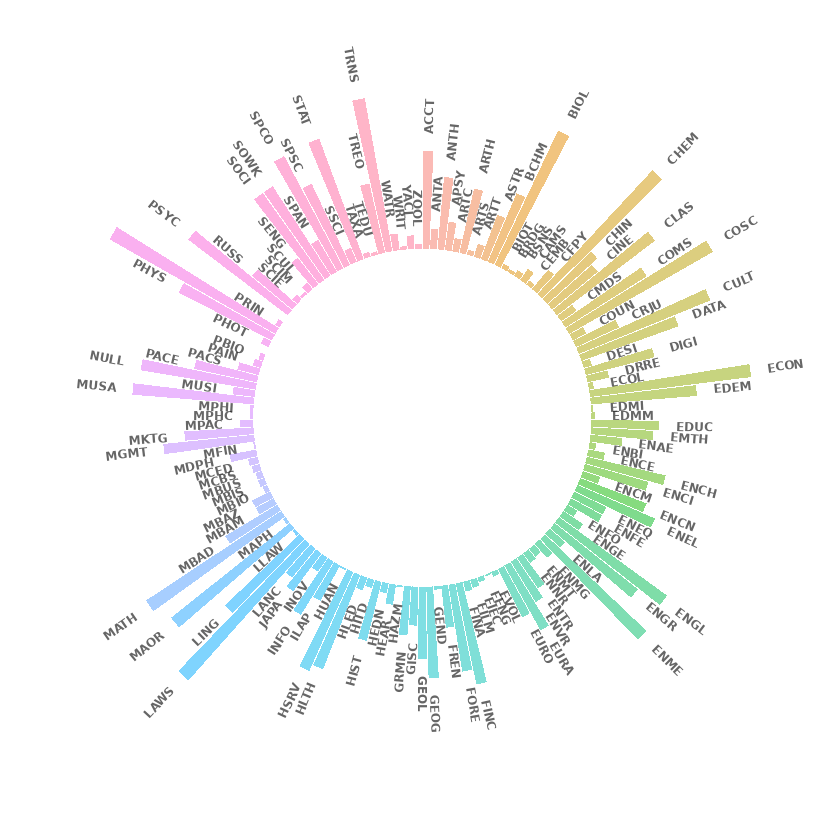

In [32]:
data <- subjects %>% 
             select(course_code) %>% 
             rename(subject_name = course_code) %>% 
             mutate(subject_name = substr(subject_name, 1,4)) %>% 
             group_by(subject_name) %>% 
             summarise(courses_in_subject=n(), per=courses_in_subject/nrow(subjects)) %>%
             mutate(labels = scales::percent(per))


# Set a number of 'empty bar' to add at the end of each group
empty_bar <- 4
to_add <- data.frame( matrix(NA, empty_bar*nlevels(data$subject_name), ncol(data)) )
colnames(to_add) <- colnames(data)
to_add$subject_name <- rep(levels(data$subject_name), each=empty_bar)
data <- rbind(data, to_add)
data <- data %>% arrange(subject_name)
data$id <- seq(1, nrow(data))

 
# Get the name and the y position of each label
label_data <- data
number_of_bar <- nrow(label_data)
angle <- 90 - 360 * (label_data$id-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
label_data$hjust <- ifelse( angle < -90, 1, 0)
label_data$angle <- ifelse(angle < -90, angle+180, angle)
 
# Make the plot
plot_courses_in_subjects <- ggplot(data, aes(x=as.factor(id), y=courses_in_subject, fill=subject_name)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar
  geom_bar(stat="identity", alpha=0.5) +
  ylim(-100,120) +
  theme_minimal() +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-1,4), "cm") 
  ) +
  coord_polar() + 
  geom_text(data=label_data, aes(x=id, y=courses_in_subject+10, label=subject_name, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=2.5, angle= label_data$angle, inherit.aes = FALSE ) 
 
plot_courses_in_subjects

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



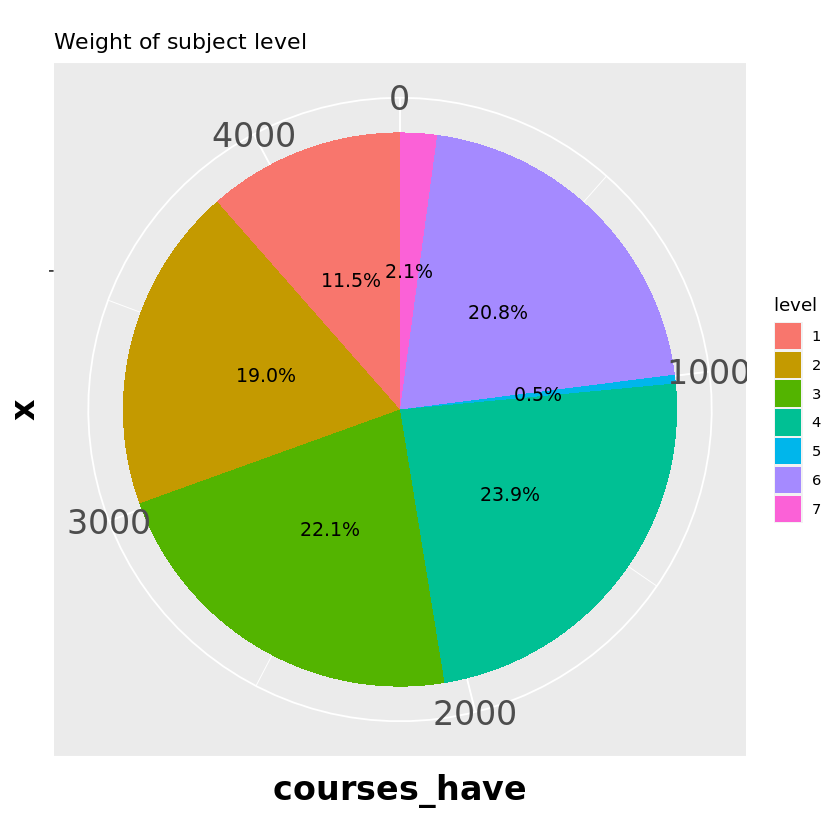

In [7]:
# data <- subjects %>% 
#                     select(course_code) %>% 
#                     rename(subject_name = course_code) %>% 
#                     mutate(subject_name = substr(subject_name, 1,4)) %>% 
#                     group_by(subject_name) %>% 
#                     summarise(courses_in_subject=n(), per=courses_in_subject/nrow(subjects)) %>%
#                     mutate(labels = scales::percent(per))

data_level <- subjects %>% 
                    select(course_code) %>%
                    mutate(level = substr(course_code, 5,5)) %>% 
                    group_by(level) %>% 
                    summarise(courses_have=n()) %>% 
                    filter(level >= 1) %>%
                    mutate(per = courses_have/sum(courses_have)) %>% 
                    mutate(labels = scales::percent(per))

pie_level_weight<- ggplot(data_level, aes(x="", y=courses_have, fill=level))+
        geom_bar(width = 1, stat = "identity") + 
        coord_polar("y", start=0) + 
        geom_text(aes(label = labels),position = position_stack(vjust = 0.5), size=4) +
        coord_polar(theta = "y") +
        labs( title = "Weight of subject level") + 
        theme(axis.text=element_text(size=20),
        axis.title=element_text(size=20,face="bold"))
pie_level_weight

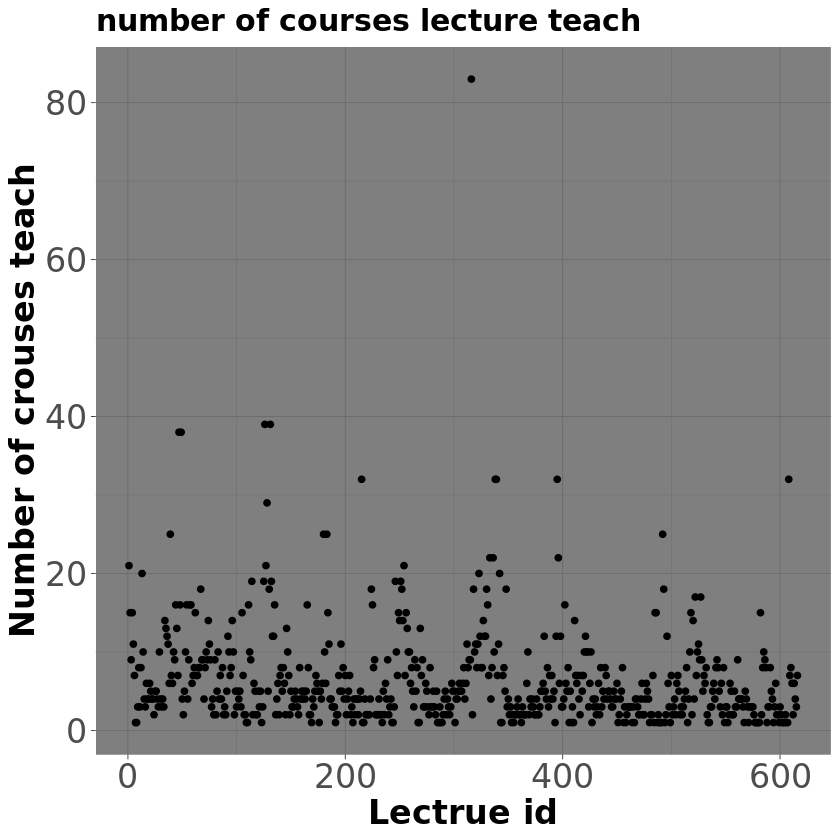

In [12]:

data_lectrue_teach <- class_data %>% 
    group_by(lecturer_id) %>%
    summarise(number_courses_teach=n())

data_lectrue_teach %>% 
                ggplot(aes(x=lecturer_id, y=number_courses_teach)) +
                geom_point()  +
                theme_dark() + 
                theme(plot.title = element_text(size = 18, face = "bold")) + 
                labs(
                    title = "number of courses lecture teach",
                     x = "Lectrue id",
                     y = "Number of crouses teach") + 
                theme(axis.text=element_text(size=20),
                axis.title=element_text(size=20,face="bold"))

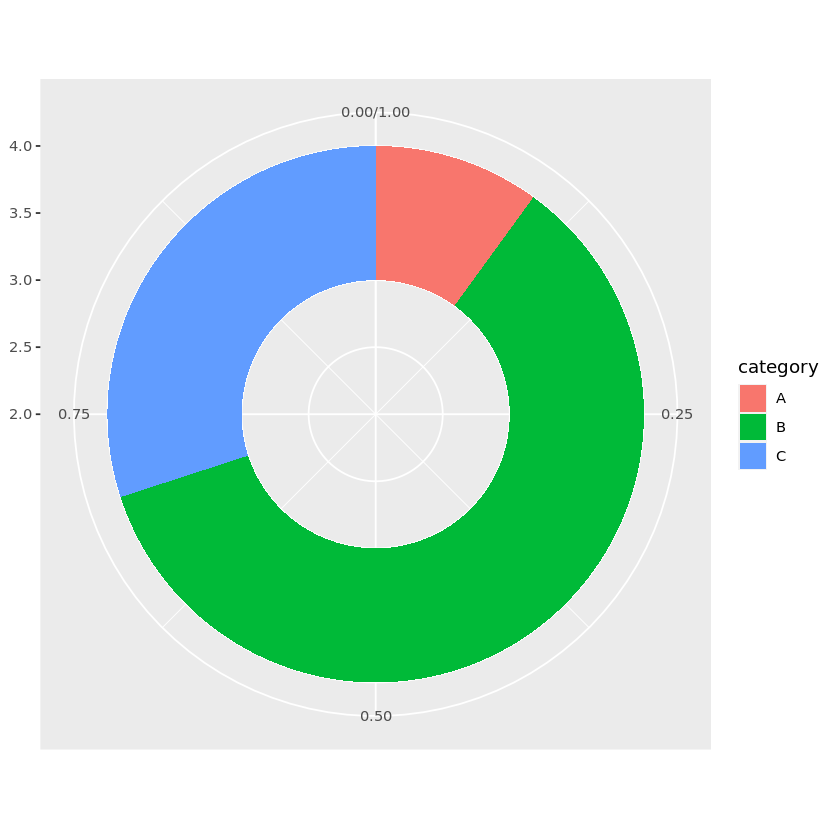

In [13]:
library(ggplot2)
 
# Create test data.
data <- data.frame(
  category=c("A", "B", "C"),
  count=c(10, 60, 30)
)
 
# Compute percentages
data$fraction = data$count / sum(data$count)

# Compute the cumulative percentages (top of each rectangle)
data$ymax = cumsum(data$fraction)

# Compute the bottom of each rectangle
data$ymin = c(0, head(data$ymax, n=-1))
 
# Make the plot
ggplot(data, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=category)) +
     geom_rect() +
     coord_polar(theta="y") + # Try to remove that to understand how the chart is built initially
     xlim(c(2, 4)) # Try t

### Task (e): APIs (2 marks)

Identify a web service offering data through an API. Access the API using `httr` and collect the information you care about. Convert the data into a dataframe (or more than one). Represent it graphically in a meaningful way.

In [125]:
library(httr)
library(jsonlite)



Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




In [185]:
get_all_pokemons <- function(url, pokemon_list){
    if (missing(url)){
        url = "https://pokeapi.co/api/v2/pokemon/"
    }
    if (missing(pokemon_list)){
        pokemon_list <- c()
    }
    r <- GET(url)
    jsonRespText <- content(r, as="text") 
    jsonRespText <- fromJSON(jsonRespText)
    next_url <- jsonRespText$'next'
    print(class(jsonRespText$result))
    print(names(jsonRespText$result))
    jsonRespText <- data.frame(name=jsonRespText$results$name, url=jsonRespText$results$url)
    pokemon_list <- c(pokemon_list, jsonRespText)
    if (!is.null(next_url)){
        return(get_all_pokemons(next_url, pokemon_list))
    }
    return(pokemon_list)
}
get_pokemon <- function(url){
    r <- GET(url)
    jsonRespText <- content(r, as="text") 
    jsonRespText <- fromJSON(jsonRespText)
    print(jsonRespText)

    jsonRespText <- jsonRespText$results
    print(jsonRespText)
}

get_all_pokemons() 
#get_pokemon('https://pokeapi.co/api/v2/pokemon/10146/')

[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1] "name" "url" 
[1] "data.frame"
[1]

$name
 [1] "bulbasaur"  "ivysaur"    "venusaur"   "charmander" "charmeleon"
 [6] "charizard"  "squirtle"   "wartortle"  "blastoise"  "caterpie"  
[11] "metapod"    "butterfree" "weedle"     "kakuna"     "beedrill"  
[16] "pidgey"     "pidgeotto"  "pidgeot"    "rattata"    "raticate"  

$url
 [1] "https://pokeapi.co/api/v2/pokemon/1/" 
 [2] "https://pokeapi.co/api/v2/pokemon/2/" 
 [3] "https://pokeapi.co/api/v2/pokemon/3/" 
 [4] "https://pokeapi.co/api/v2/pokemon/4/" 
 [5] "https://pokeapi.co/api/v2/pokemon/5/" 
 [6] "https://pokeapi.co/api/v2/pokemon/6/" 
 [7] "https://pokeapi.co/api/v2/pokemon/7/" 
 [8] "https://pokeapi.co/api/v2/pokemon/8/" 
 [9] "https://pokeapi.co/api/v2/pokemon/9/" 
[10] "https://pokeapi.co/api/v2/pokemon/10/"
[11] "https://pokeapi.co/api/v2/pokemon/11/"
[12] "https://pokeapi.co/api/v2/pokemon/12/"
[13] "https://pokeapi.co/api/v2/pokemon/13/"
[14] "https://pokeapi.co/api/v2/pokemon/14/"
[15] "https://pokeapi.co/api/v2/pokemon/15/"
[16] "https://pokeapi.co/api/v2/pokemon/16/"
[17] "https://pokeapi.co/api/v2/pokemon/17/"
[18] "https://pokeapi.co/api/v2/pokemon/18/"
[19] "https://pokeapi.co/api/v2/pokemon/19/"
[20] "https://pokeapi.co/api/v2/pokemon/20/"

$name
 [1] "spearow"    "fearow"     "ekans"      "arbok"      "pikachu"   
 [6] "raichu"     "sandshrew"  "sandslash"  "nidoran-f"  "nidorina"  
[11] "nidoqueen"  "nidoran-m"  "nidorino"   "nidoking"   "clefairy"  
[16] "clefable"   "vulpix"     "ninetales"  "jigglypuff" "wigglytuff"

$url
 [1] "https://pokeapi.co/api/v2/pokemon/21/"
 [2] "https://pokeapi.co/api/v2/pokemon/22/"
 [3] "https://pokeapi.co/api/v2/pokemon/23/"
 [4] "https://pokeapi.co/api/v2/pokemon/24/"
 [5] "https://pokeapi.co/api/v2/pokemon/25/"
 [6] "https://pokeapi.co/api/v2/pokemon/26/"
 [7] "https://pokeapi.co/api/v2/pokemon/27/"
 [8] "https://pokeapi.co/api/v2/pokemon/28/"
 [9] "https://pokeapi.co/api/v2/pokemon/29/"
[10] "https://pokeapi.co/api/v2/pokemon/30/"
[11] "https://pokeapi.co/api/v2/pokemon/31/"
[12] "https://pokeapi.co/api/v2/pokemon/32/"
[13] "https://pokeapi.co/api/v2/pokemon/33/"
[14] "https://pokeapi.co/api/v2/pokemon/34/"
[15] "https://pokeapi.co/api/v2/pokemon/35/"
[16] "https://pokeapi.co/api/v2/pokemon/36/"
[17] "https://pokeapi.co/api/v2/pokemon/37/"
[18] "https://pokeapi.co/api/v2/pokemon/38/"
[19] "https://pokeapi.co/api/v2/pokemon/39/"
[20] "https://pokeapi.co/api/v2/pokemon/40/"

$name
 [1] "zubat"     "golbat"    "oddish"    "gloom"     "vileplume" "paras"    
 [7] "parasect"  "venonat"   "venomoth"  "diglett"   "dugtrio"   "meowth"   
[13] "persian"   "psyduck"   "golduck"   "mankey"    "primeape"  "growlithe"
[19] "arcanine"  "poliwag"  

$url
 [1] "https://pokeapi.co/api/v2/pokemon/41/"
 [2] "https://pokeapi.co/api/v2/pokemon/42/"
 [3] "https://pokeapi.co/api/v2/pokemon/43/"
 [4] "https://pokeapi.co/api/v2/pokemon/44/"
 [5] "https://pokeapi.co/api/v2/pokemon/45/"
 [6] "https://pokeapi.co/api/v2/pokemon/46/"
 [7] "https://pokeapi.co/api/v2/pokemon/47/"
 [8] "https://pokeapi.co/api/v2/pokemon/48/"
 [9] "https://pokeapi.co/api/v2/pokemon/49/"
[10] "https://pokeapi.co/api/v2/pokemon/50/"
[11] "https://pokeapi.co/api/v2/pokemon/51/"
[12] "https://pokeapi.co/api/v2/pokemon/52/"
[13] "https://pokeapi.co/api/v2/pokemon/53/"
[14] "https://pokeapi.co/api/v2/pokemon/54/"
[15] "https://pokeapi.co/api/v2/pokemon/55/"
[16] "https://pokeapi.co/api/v2/pokemon/56/"
[17] "https://pokeapi.co/api/v2/pokemon/57/"
[18] "https://pokeapi.co/api/v2/pokemon/58/"
[19] "https://pokeapi.co/api/v2/pokemon/59/"
[20] "https://pokeapi.co/api/v2/pokemon/60/"

$name
 [1] "poliwhirl"  "poliwrath"  "abra"       "kadabra"    "alakazam"  
 [6] "machop"     "machoke"    "machamp"    "bellsprout" "weepinbell"
[11] "victreebel" "tentacool"  "tentacruel" "geodude"    "graveler"  
[16] "golem"      "ponyta"     "rapidash"   "slowpoke"   "slowbro"   

$url
 [1] "https://pokeapi.co/api/v2/pokemon/61/"
 [2] "https://pokeapi.co/api/v2/pokemon/62/"
 [3] "https://pokeapi.co/api/v2/pokemon/63/"
 [4] "https://

### Comment, explain and present the work in a clear way (1 marks)